In [179]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm

In [180]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),  
    transforms.ToTensor(),  
])

In [181]:
dataset = datasets.ImageFolder(root='dataset', transform=transform)

In [182]:
class_names = dataset.classes
class_names

['Beagle',
 'Boxer',
 'Bulldog',
 'Dachshund',
 'German_Shepherd',
 'Golden_Retriever',
 'Labrador_Retriever',
 'Poodle',
 'Rottweiler',
 'Yorkshire_Terrier']

In [183]:
img,labels = dataset[5]
input_shape = img.shape[0]
num_classes = len(dataset.classes)
(input_shape,num_classes)

(3, 10)

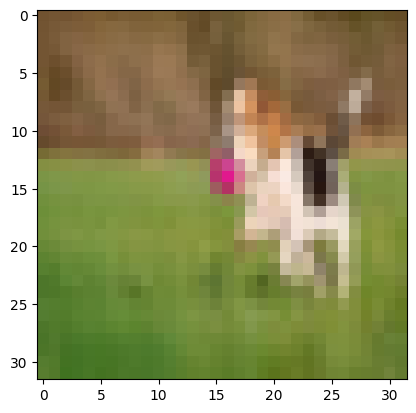

In [184]:
plt.imshow(np.transpose(img, (1, 2, 0)))
plt.show()

In [185]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [186]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


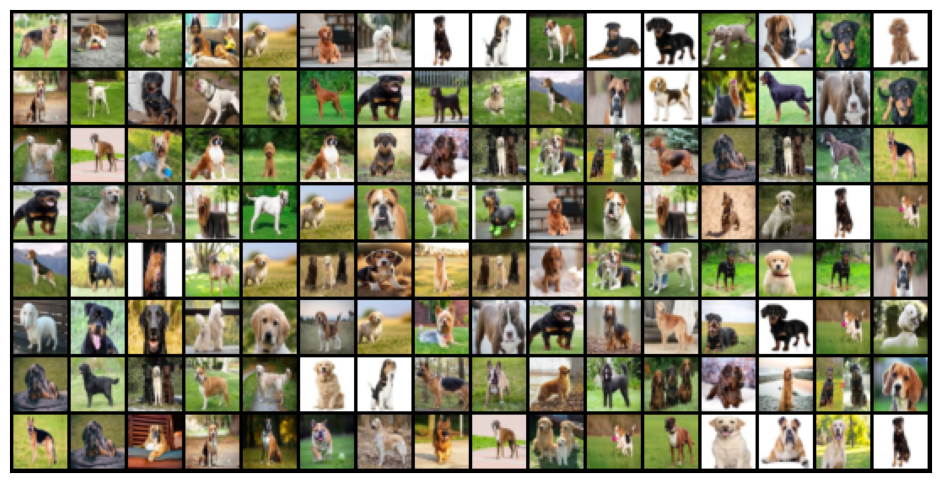

In [187]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break
show_batch(train_loader)

In [188]:
num_epochs = 100
lr = 0.0001

In [189]:
def conv_block(in_channels,out_channels,pool=False):
    layers = [
        nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(negative_slope=0.01, inplace=True),
    ]
    if pool:
        layers.append (nn.AvgPool2d(2))
    return nn.Sequential(*layers)

In [190]:
class ResNet(nn.Module):
    def __init__(self,in_channels,num_classes):
        super().__init__()
        # 3 x 32 x 32
        self.conv1 = conv_block(in_channels,64) # 64 x 32 x 32
        self.conv2 = conv_block(64,128,pool=True) #128 x 16 x 16
        self.res1 = nn.Sequential(conv_block(128,128),
                                  conv_block(128,128)
                                  ) # 128 x 16 x 16
        
        self.conv3 = conv_block(128,256,pool=True) # 256 x 8 x 8
        self.conv4 = conv_block(256,512,pool=True) #512 x 4 x 4
        self.res2 = nn.Sequential(conv_block(512,512),
                                  conv_block(512,512),
                                  ) # 512 x 4 x 4
        
        self.conv5 = conv_block(512,1028) # 1028 x 4 x 4
        self.conv6 = conv_block (1028,2056,pool=True) # 2056 x 2 x 2
        self.res3 = nn.Sequential(conv_block(2056,2056),
                                  conv_block(2056,2056)
                                  ) # 2056 x 2 x 2
        
        self.classifier = nn.Sequential (
            nn.AvgPool2d(2), # 2056 x 1 x 1
            nn.Flatten(), # 2056 
            nn.Dropout(0.2),
            nn.Linear(2056,num_classes)
        )
        
    def forward (self,xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.classifier(out)
        return out

In [191]:
device = torch.device('cuda')

In [192]:
model = ResNet(3, num_classes).to(device)

In [193]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=lr)


In [194]:
import matplotlib.pyplot as plt

def train(train_loader, model, criterion, optimizer, num_epochs):
    train_losses = []
    train_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        total_correct = 0
        total_samples = 0
        total_loss = 0.0
        train_loader = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False)

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)
            total_loss += loss.item()
        
        epoch_loss = total_loss / len(train_loader)
        epoch_acc = total_correct / total_samples * 100
        
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.2f}%')

    # Plot the training loss and accuracy
    epochs = range(1, num_epochs + 1)
    
    plt.figure(figsize=(12, 4))
    
    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b', label='Training loss')
    plt.title('Training loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot training accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'r', label='Training accuracy')
    plt.title('Training accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.show()



    
    
    
    
    

Epoch [1/100], Train Loss: 1.7925, Train Accuracy: 43.34%


Epoch [2/100], Train Loss: 0.4786, Train Accuracy: 86.29%


Epoch [3/100], Train Loss: 0.2100, Train Accuracy: 97.28%


Epoch [4/100], Train Loss: 0.3093, Train Accuracy: 92.88%


Epoch [5/100], Train Loss: 0.3930, Train Accuracy: 90.30%


Epoch [6/100], Train Loss: 0.3336, Train Accuracy: 94.44%


Epoch [7/100], Train Loss: 0.2020, Train Accuracy: 94.70%


Epoch [8/100], Train Loss: 0.0744, Train Accuracy: 99.22%


Epoch [9/100], Train Loss: 0.0478, Train Accuracy: 99.61%


Epoch [10/100], Train Loss: 0.1347, Train Accuracy: 99.74%


Epoch [11/100], Train Loss: 0.3123, Train Accuracy: 95.60%


Epoch [12/100], Train Loss: 0.4914, Train Accuracy: 93.01%


Epoch [13/100], Train Loss: 0.2720, Train Accuracy: 93.92%


Epoch [14/100], Train Loss: 0.3715, Train Accuracy: 95.34%


Epoch [15/100], Train Loss: 0.4216, Train Accuracy: 89.52%


Epoch [16/100], Train Loss: 0.1625, Train Accuracy: 98.06%


Epoch [17/100], Train Loss: 0.0845, Train Accuracy: 98.71%


Epoch [18/100], Train Loss: 0.1363, Train Accuracy: 98.97%


Epoch [19/100], Train Loss: 0.4607, Train Accuracy: 90.94%


Epoch [20/100], Train Loss: 0.2474, Train Accuracy: 93.01%


Epoch [21/100], Train Loss: 0.2745, Train Accuracy: 92.76%


Epoch [22/100], Train Loss: 0.6809, Train Accuracy: 90.56%


Epoch [23/100], Train Loss: 0.5540, Train Accuracy: 89.78%


Epoch [24/100], Train Loss: 0.3269, Train Accuracy: 91.20%


Epoch [25/100], Train Loss: 0.5652, Train Accuracy: 96.77%


Epoch [26/100], Train Loss: 0.3287, Train Accuracy: 95.08%


Epoch [27/100], Train Loss: 0.1770, Train Accuracy: 94.83%


Epoch [28/100], Train Loss: 0.1566, Train Accuracy: 97.93%


Epoch [29/100], Train Loss: 0.0665, Train Accuracy: 99.35%


Epoch [30/100], Train Loss: 0.0561, Train Accuracy: 99.22%


Epoch [31/100], Train Loss: 0.0348, Train Accuracy: 99.35%


Epoch [32/100], Train Loss: 0.2203, Train Accuracy: 99.61%


Epoch [33/100], Train Loss: 0.3684, Train Accuracy: 92.76%


Epoch [34/100], Train Loss: 0.1746, Train Accuracy: 95.47%


Epoch [35/100], Train Loss: 0.0930, Train Accuracy: 98.84%


Epoch [36/100], Train Loss: 0.0778, Train Accuracy: 98.32%


Epoch [37/100], Train Loss: 0.1295, Train Accuracy: 98.71%


Epoch [38/100], Train Loss: 0.1541, Train Accuracy: 97.93%


Epoch [39/100], Train Loss: 0.1808, Train Accuracy: 96.38%


Epoch [40/100], Train Loss: 0.3255, Train Accuracy: 93.40%


Epoch [41/100], Train Loss: 0.3572, Train Accuracy: 96.38%


Epoch [42/100], Train Loss: 0.3169, Train Accuracy: 94.18%


Epoch [43/100], Train Loss: 0.3502, Train Accuracy: 91.85%


Epoch [44/100], Train Loss: 0.2894, Train Accuracy: 90.30%


Epoch [45/100], Train Loss: 0.1071, Train Accuracy: 97.28%


Epoch [46/100], Train Loss: 0.0585, Train Accuracy: 99.22%


Epoch [47/100], Train Loss: 0.1710, Train Accuracy: 99.74%


Epoch [48/100], Train Loss: 0.2307, Train Accuracy: 97.54%


Epoch [49/100], Train Loss: 0.2881, Train Accuracy: 94.44%


Epoch [50/100], Train Loss: 0.1753, Train Accuracy: 97.67%


Epoch [51/100], Train Loss: 0.1405, Train Accuracy: 95.86%


Epoch [52/100], Train Loss: 0.1067, Train Accuracy: 97.54%


Epoch [53/100], Train Loss: 0.0743, Train Accuracy: 97.93%


Epoch [54/100], Train Loss: 0.4739, Train Accuracy: 99.48%


Epoch [55/100], Train Loss: 0.1585, Train Accuracy: 97.54%


Epoch [56/100], Train Loss: 0.3092, Train Accuracy: 96.25%


Epoch [57/100], Train Loss: 0.1157, Train Accuracy: 96.25%


Epoch [58/100], Train Loss: 0.0610, Train Accuracy: 98.71%


Epoch [59/100], Train Loss: 0.0110, Train Accuracy: 99.87%


Epoch [60/100], Train Loss: 0.1068, Train Accuracy: 99.74%


Epoch [61/100], Train Loss: 0.1863, Train Accuracy: 95.60%


Epoch [62/100], Train Loss: 0.4262, Train Accuracy: 96.12%


Epoch [63/100], Train Loss: 0.3584, Train Accuracy: 95.86%


Epoch [64/100], Train Loss: 0.2661, Train Accuracy: 95.21%


Epoch [65/100], Train Loss: 0.1633, Train Accuracy: 96.51%


Epoch [66/100], Train Loss: 0.1155, Train Accuracy: 98.06%


Epoch [67/100], Train Loss: 0.1828, Train Accuracy: 99.48%


Epoch [68/100], Train Loss: 0.0399, Train Accuracy: 99.22%


Epoch [69/100], Train Loss: 0.0558, Train Accuracy: 99.87%


Epoch [70/100], Train Loss: 0.0661, Train Accuracy: 99.74%


Epoch [71/100], Train Loss: 0.0295, Train Accuracy: 99.09%


Epoch [72/100], Train Loss: 0.0229, Train Accuracy: 99.74%


Epoch [73/100], Train Loss: 0.0289, Train Accuracy: 100.00%


Epoch [74/100], Train Loss: 0.1428, Train Accuracy: 99.87%


Epoch [75/100], Train Loss: 0.1712, Train Accuracy: 97.93%


Epoch [76/100], Train Loss: 0.1261, Train Accuracy: 98.58%


Epoch [77/100], Train Loss: 0.3264, Train Accuracy: 97.15%


Epoch [78/100], Train Loss: 0.1292, Train Accuracy: 96.51%


Epoch [79/100], Train Loss: 0.1469, Train Accuracy: 95.86%


Epoch [80/100], Train Loss: 0.0594, Train Accuracy: 98.58%


Epoch [81/100], Train Loss: 0.1118, Train Accuracy: 98.97%


Epoch [82/100], Train Loss: 0.1423, Train Accuracy: 98.97%


Epoch [83/100], Train Loss: 0.3988, Train Accuracy: 95.99%


Epoch [84/100], Train Loss: 0.5412, Train Accuracy: 95.34%


Epoch [85/100], Train Loss: 0.1833, Train Accuracy: 95.08%


Epoch [86/100], Train Loss: 0.1417, Train Accuracy: 98.06%


Epoch [87/100], Train Loss: 0.2259, Train Accuracy: 95.60%


Epoch [88/100], Train Loss: 0.1897, Train Accuracy: 99.48%


Epoch [89/100], Train Loss: 0.2563, Train Accuracy: 97.93%


Epoch [90/100], Train Loss: 0.1030, Train Accuracy: 97.67%


Epoch [91/100], Train Loss: 0.1020, Train Accuracy: 98.45%


Epoch [92/100], Train Loss: 0.0665, Train Accuracy: 98.06%


Epoch [93/100], Train Loss: 0.0364, Train Accuracy: 99.87%


Epoch [94/100], Train Loss: 0.0099, Train Accuracy: 100.00%


Epoch [95/100], Train Loss: 0.0144, Train Accuracy: 100.00%


Epoch [96/100], Train Loss: 0.0393, Train Accuracy: 99.87%


Epoch [97/100], Train Loss: 0.0134, Train Accuracy: 100.00%


Epoch [98/100], Train Loss: 0.0068, Train Accuracy: 100.00%


Epoch [99/100], Train Loss: 0.0146, Train Accuracy: 99.87%


Epoch [100/100], Train Loss: 0.0078, Train Accuracy: 100.00%


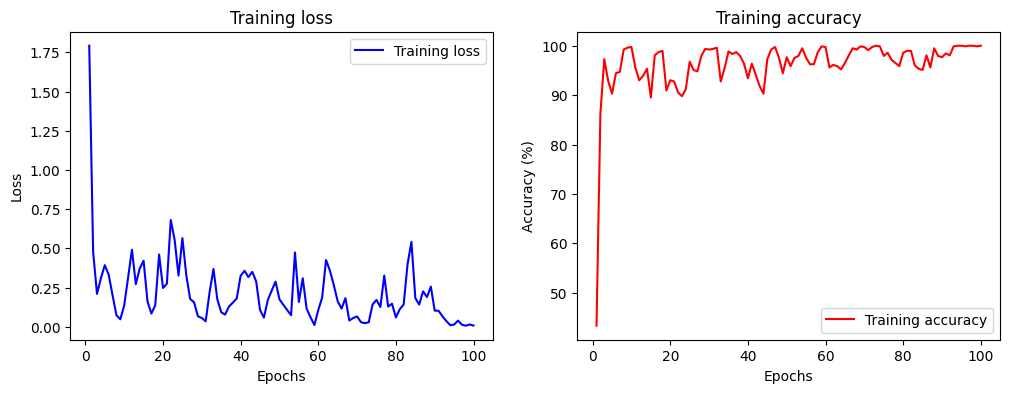

In [195]:
train(train_loader, model, criterion, optimizer, num_epochs)


In [196]:
torch.save(model.state_dict(), 'resnet_cnn.pth')


Accuracy: 1.00


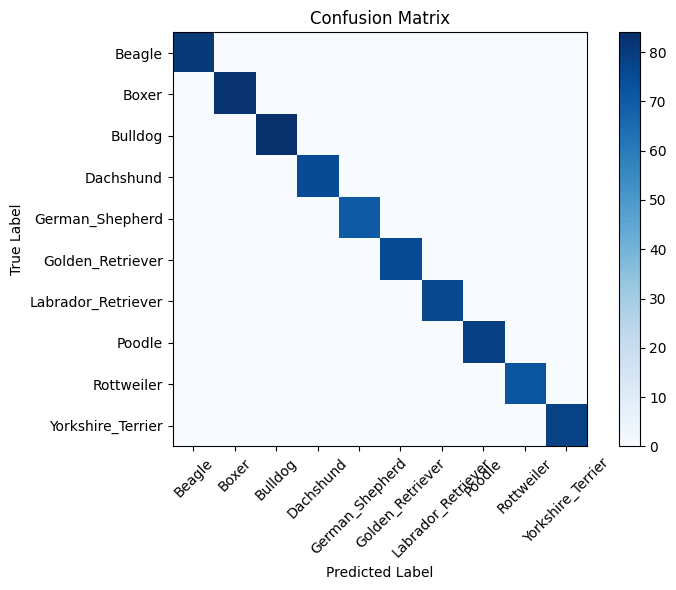

                    precision    recall  f1-score   support

            Beagle       1.00      1.00      1.00        81
             Boxer       1.00      1.00      1.00        83
           Bulldog       1.00      1.00      1.00        84
         Dachshund       1.00      1.00      1.00        75
   German_Shepherd       1.00      1.00      1.00        70
  Golden_Retriever       1.00      1.00      1.00        75
Labrador_Retriever       1.00      1.00      1.00        76
            Poodle       1.00      1.00      1.00        79
        Rottweiler       1.00      1.00      1.00        72
 Yorkshire_Terrier       1.00      1.00      1.00        78

          accuracy                           1.00       773
         macro avg       1.00      1.00      1.00       773
      weighted avg       1.00      1.00      1.00       773



In [197]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

predictions = np.array(predictions)
true_labels = np.array(true_labels)
accuracy = np.mean(predictions == true_labels)
print(f'Accuracy: {accuracy:.2f}')

class_names = dataset.classes
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

print(classification_report(true_labels, predictions, target_names=class_names))

Testing Accuracy: 0.99


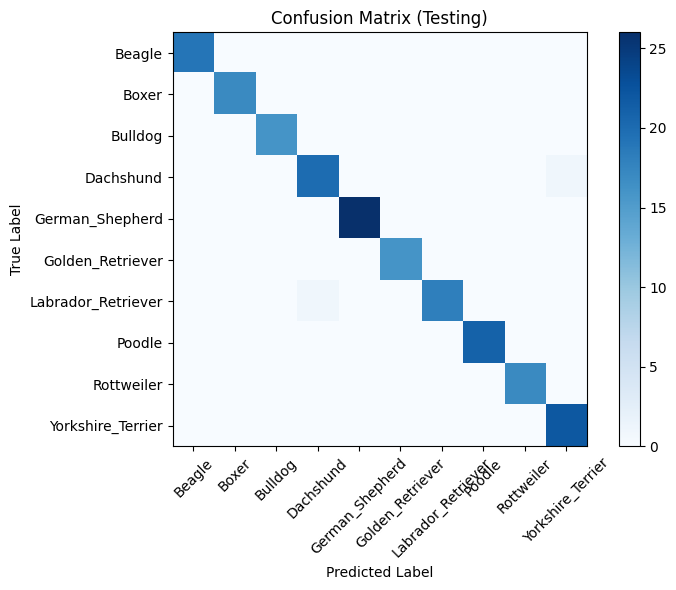

                    precision    recall  f1-score   support

            Beagle       1.00      1.00      1.00        19
             Boxer       1.00      1.00      1.00        17
           Bulldog       1.00      1.00      1.00        16
         Dachshund       0.95      0.95      0.95        21
   German_Shepherd       1.00      1.00      1.00        26
  Golden_Retriever       1.00      1.00      1.00        16
Labrador_Retriever       1.00      0.95      0.97        19
            Poodle       1.00      1.00      1.00        21
        Rottweiler       1.00      1.00      1.00        17
 Yorkshire_Terrier       0.96      1.00      0.98        22

          accuracy                           0.99       194
         macro avg       0.99      0.99      0.99       194
      weighted avg       0.99      0.99      0.99       194



In [198]:

model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

predictions = np.array(predictions)
true_labels = np.array(true_labels)
accuracy = np.mean(predictions == true_labels)
print(f'Testing Accuracy: {accuracy:.2f}')

conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Testing)')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

print(classification_report(true_labels, predictions, target_names=class_names))

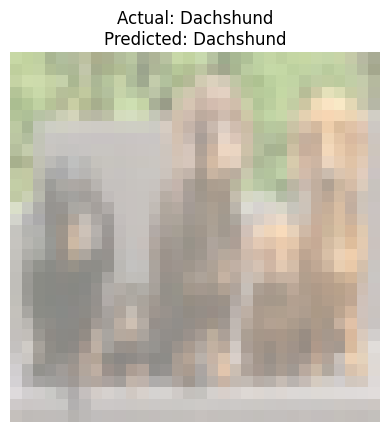

Image 43:
Actual class: Dachshund
Predicted class: Dachshund
------------------------


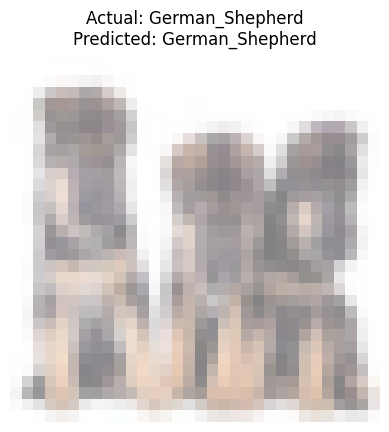

Image 186:
Actual class: German_Shepherd
Predicted class: German_Shepherd
------------------------


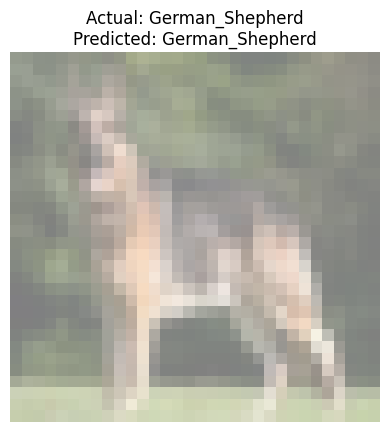

Image 164:
Actual class: German_Shepherd
Predicted class: German_Shepherd
------------------------


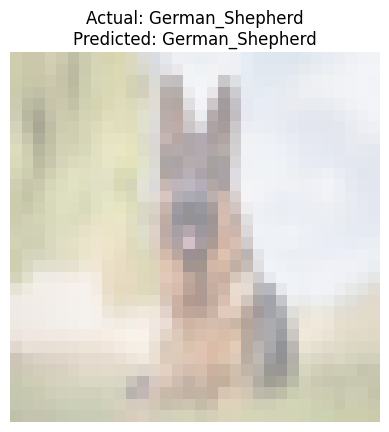

Image 178:
Actual class: German_Shepherd
Predicted class: German_Shepherd
------------------------


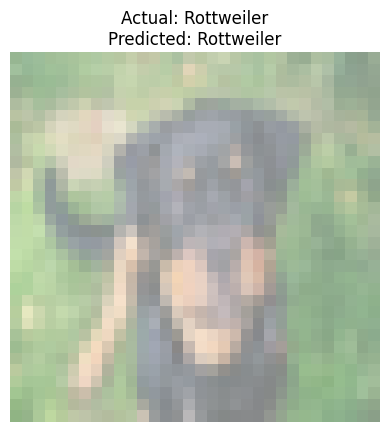

Image 177:
Actual class: Rottweiler
Predicted class: Rottweiler
------------------------


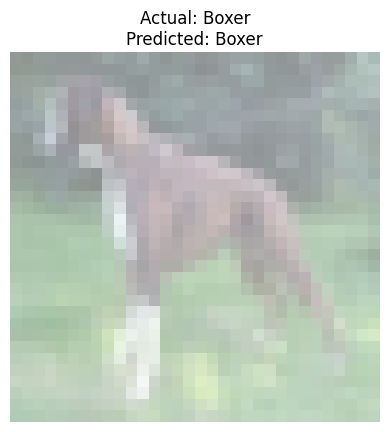

Image 77:
Actual class: Boxer
Predicted class: Boxer
------------------------


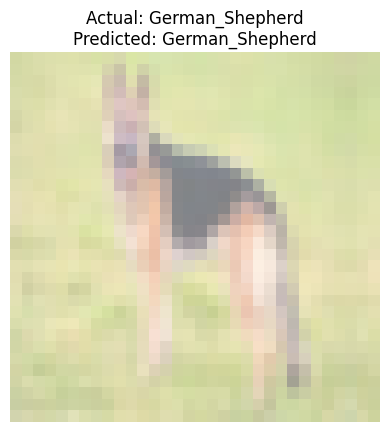

Image 61:
Actual class: German_Shepherd
Predicted class: German_Shepherd
------------------------


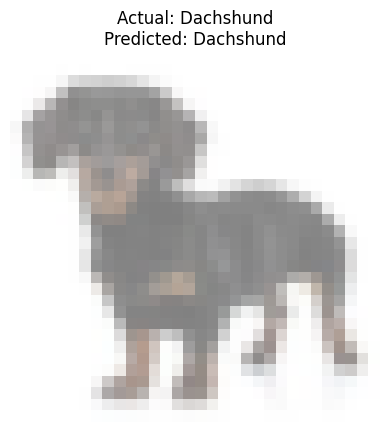

Image 145:
Actual class: Dachshund
Predicted class: Dachshund
------------------------


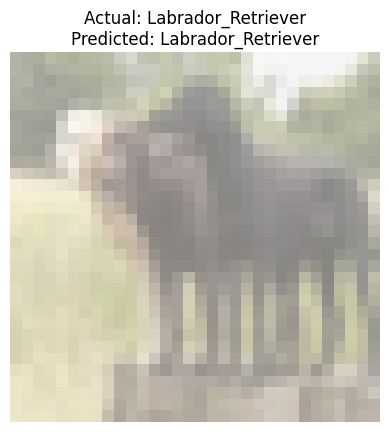

Image 128:
Actual class: Labrador_Retriever
Predicted class: Labrador_Retriever
------------------------


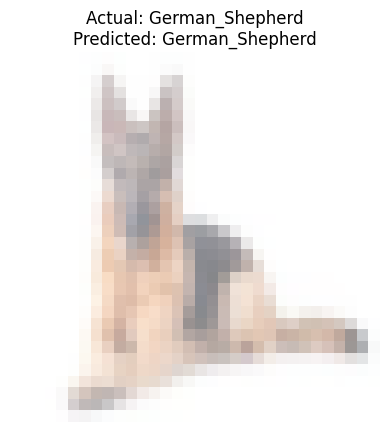

Image 119:
Actual class: German_Shepherd
Predicted class: German_Shepherd
------------------------


In [199]:
import torch
import matplotlib.pyplot as plt
import random
import numpy as np

# Ensure CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming model is defined, loaded, and moved to GPU
# model = YourModel().to(device)
# model.load_state_dict(torch.load('model_path.pth'))
model.eval()

# Assuming test_loader is defined
# Make sure test_loader has shuffle=False to maintain consistent indexing

# Get a list of class names (adjust this to match your dataset)

def imshow(img):
    img = img.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')

# Get total number of images in test_loader
total_images = len(test_loader.dataset)

# Generate 10 random indices
random_indices = random.sample(range(total_images), 10)

for idx in random_indices:
    # Get the image and label
    image, label = test_loader.dataset[idx]
    
    # Add batch dimension and move to GPU
    image = image.unsqueeze(0).to(device)
    label = torch.tensor(label).to(device)

    # Pass the image through the model
    with torch.no_grad():
        output = model(image)
    
    # Get the predicted class
    _, predicted = torch.max(output, 1)

    # Display the image and results
    plt.figure()
    imshow(image.squeeze(0).cpu())
    plt.title(f"Actual: {class_names[label.item()]}\nPredicted: {class_names[predicted.item()]}")
    plt.show()

    print(f"Image {idx}:")
    print(f"Actual class: {class_names[label.item()]}")
    print(f"Predicted class: {class_names[predicted.item()]}")
    print("------------------------")

In [200]:
from PIL import Image
import torch
import torchvision.transforms as transforms

def predict_image_class(image_path, model, class_names):
    # Load the image
    entered_image = Image.open(image_path)

    # Apply transformations
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
    ])

    transformed_image = transform(entered_image).unsqueeze(0)  # Add batch dimension

    # Ensure model is in evaluation mode
    model.eval()

    # Move the transformed image to the device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    transformed_image = transformed_image.to(device)

    # Forward pass
    with torch.no_grad():
        outputs = model(transformed_image)

    # Get predictions
    _, predicted = torch.max(outputs, 1)
    predicted_class = predicted.item()  # Assuming single image batch

    # Optionally, get predicted probabilities
    probs = torch.softmax(outputs, dim=1)
    predicted_prob = probs[0, predicted_class].item()

    # Print and return results
    print(f'Predicted Class: {class_names[predicted_class]}, Probability: {predicted_prob:.2f}')
    
    plt.imshow(entered_image)
    plt.show()


Predicted Class: Rottweiler, Probability: 0.55


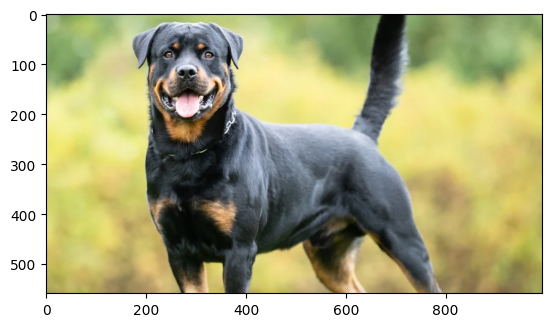

In [201]:
predict_image_class('img1.jpg', model, class_names)

Predicted Class: German_Shepherd, Probability: 1.00


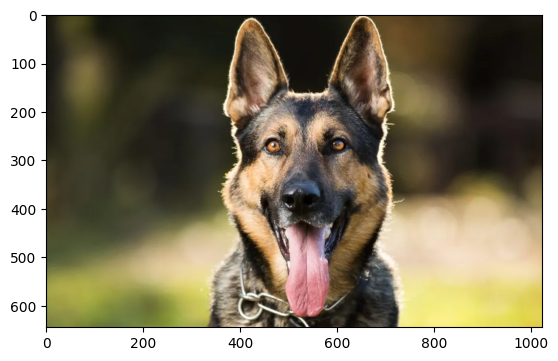

In [202]:
predict_image_class('img2.jpg', model, class_names)

In [203]:
class_names

['Beagle',
 'Boxer',
 'Bulldog',
 'Dachshund',
 'German_Shepherd',
 'Golden_Retriever',
 'Labrador_Retriever',
 'Poodle',
 'Rottweiler',
 'Yorkshire_Terrier']

Predicted Class: Golden_Retriever, Probability: 1.00


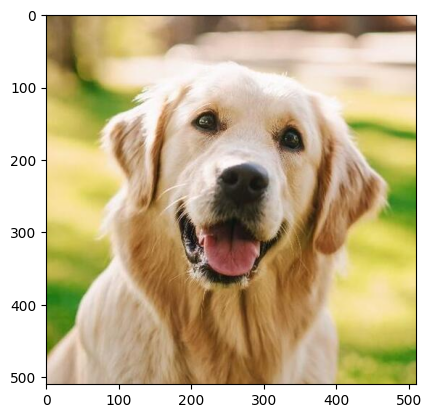

In [204]:
predict_image_class('img3.jpg', model, class_names)